In [49]:
import numpy as np
import pandas as pd
import itertools
import statsmodels
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import statsmodels.tsa.statespace.sarimax
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error


### Esetablishing Current Rent Prices

In [3]:
rent = pd.read_csv('Rentals.csv')

In [4]:
rent.head()

,RegionID,RegionName,SizeRank,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,...,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11
0,102001,United States,0,1318.0,1323,1328.0,1334,1339,1345,1350,...,1704,1722,1741,1760,1779,1798,1818,1838.0,1858.0,1879
1,394913,"New York, NY",1,2291.0,2301,2311.0,2322,2332,2342,2352,...,2532,2553,2573,2596,2619,2641,2667,2692.0,2717.0,2744
2,753899,"Los Angeles-Long Beach-Anaheim, CA",2,1795.0,1806,1816.0,1827,1838,1849,1860,...,2465,2487,2509,2531,2554,2576,2600,2624.0,2648.0,2673
3,394463,"Chicago, IL",3,1412.0,1416,1419.0,1423,1427,1430,1434,...,1633,1643,1653,1663,1674,1684,1696,1707.0,1718.0,1730
4,394514,"Dallas-Fort Worth, TX",4,1136.0,1140,1143.0,1147,1151,1154,1158,...,1510,1530,1549,1570,1590,1610,1631,1652.0,1674.0,1696


In [5]:
rent['State'] = rent['RegionName'].str.slice(-2)

In [6]:
current_rent_prices = rent[['RegionName', 'State', '2021-10']]

### Establishing Current Sale Prices

In [7]:
#Create Sale DF

sale = pd.read_csv('home_values.csv')

sale.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30
0,102001,0,United States,Country,NaN,127104.0,127448.0,127809.0,128546.0,129288.0,...,274766.0,278419.0,282276.0,286980.0,292503.0,298382.0,303772.0,308393.0,312486.0,316368.0
1,394913,1,"New York, NY",Msa,NY,223875.0,225213.0,226416.0,228785.0,230991.0,...,520343.0,524700.0,529431.0,534932.0,542083.0,549998.0,557578.0,563469.0,568010.0,571556.0
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,231151.0,231956.0,233189.0,235533.0,238046.0,...,748563.0,756432.0,767475.0,783139.0,802944.0,823842.0,837285.0,846395.0,851153.0,858357.0
3,394463,3,"Chicago, IL",Msa,IL,169017.0,169416.0,169932.0,170965.0,172060.0,...,258870.0,260970.0,263993.0,266728.0,270524.0,274664.0,278755.0,281808.0,284452.0,287131.0
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,130276.0,130380.0,130466.0,130678.0,130900.0,...,280524.0,284541.0,290061.0,296469.0,303787.0,311586.0,319478.0,326661.0,332734.0,338194.0


In [8]:
#Create States Column

sale['State'] = sale['RegionName'].str.slice(-2)

In [9]:
#Create Current Sales Values

current_sales_values = sale[['RegionName', 'State', '2021-10-31']]

In [10]:
#Check current sales values

current_sales_values.head()

,RegionName,State,2021-10-31
0,United States,es,312486.0
1,"New York, NY",NY,568010.0
2,"Los Angeles-Long Beach-Anaheim, CA",CA,851153.0
3,"Chicago, IL",IL,284452.0
4,"Dallas-Fort Worth, TX",TX,332734.0


In [11]:
#Import Property Tax Rates

prop_taxes = pd.read_excel('PropertyTax.xlsx', 'Ptax')

#Clean column names

prop_taxes = prop_taxes.rename(columns={'Unnamed: 2': 'StateShort'})

#Check taxes df

prop_taxes.head()

,Rank,State,StateShort,Real Estate Tax Rate,Average Home Price,Annual Property Tax
0,1,Hawaii,HI,0.0028,615300,606
1,2,Alabama,AL,0.0041,142700,895
2,3,Colorado,CO,0.0051,343300,1113
3,4,Louisiana,LA,0.0055,163100,1187
4,5,District of Columbia,DC,0.0056,601500,1221


In [12]:
#Merge Sales Table with Property Tax Table

current_sales_values = current_sales_values.merge(prop_taxes[['StateShort', 'Real Estate Tax Rate']], 
                           how='inner', left_on='State', right_on='StateShort')

#Quick check on Merge Results

current_sales_values[current_sales_values['State'] == 'UT']

,RegionName,State,2021-10-31,StateShort,Real Estate Tax Rate
689,"Salt Lake City, UT",UT,539375.0,UT,0.0063
690,"Ogden, UT",UT,474251.0,UT,0.0063
691,"Provo, UT",UT,524123.0,UT,0.0063
692,"St. George, UT",UT,506551.0,UT,0.0063
693,"Cedar City, UT",UT,337688.0,UT,0.0063
694,"Summit Park, UT",UT,1122965.0,UT,0.0063
695,"Vernal, UT",UT,279791.0,UT,0.0063
696,"Heber, UT",UT,677724.0,UT,0.0063
697,"Price, UT",UT,195269.0,UT,0.0063


In [13]:
#Calculate Monthly Mortgage Payments

i = 0.03 / 12
n = 360

current_sales_values['Mortgage Payment'] = round(current_sales_values['2021-10-31'] * ((i*(1 + i)**n) / 
                                                                                      ((1 + i)** n - 1)), 2)

current_sales_values = current_sales_values.dropna()


In [14]:
#Calculate Property Tax

current_sales_values['MPT'] = round((current_sales_values['2021-10-31'] * 
                                    current_sales_values['Real Estate Tax Rate'] / 12), 2)

current_sales_values['Monthly Payment'] = current_sales_values['Mortgage Payment'] + current_sales_values['MPT']

current_sales_values.head()

,RegionName,State,2021-10-31,StateShort,Real Estate Tax Rate,Mortgage Payment,MPT,Monthly Payment
0,"New York, NY",NY,568010.0,NY,0.0172,2394.75,814.15,3208.90
1,"Buffalo, NY",NY,225172.0,NY,0.0172,949.33,322.75,1272.08
2,"Rochester, NY",NY,194463.0,NY,0.0172,819.86,278.73,1098.59
3,"Albany, NY",NY,249676.0,NY,0.0172,1052.64,357.87,1410.51
4,"Syracuse, NY",NY,178093.0,NY,0.0172,750.85,255.27,1006.12


In [15]:
#Calculate Property Tax

current_sales_values = current_sales_values.merge(
    current_rent_prices[['RegionName', '2021-10']], how='inner', on='RegionName')

#Label Rent as Rent

current_sales_values = current_sales_values.rename(columns={'2021-10': 'Monthly Rent'})

In [16]:
#Find States with Inefficienies

current_sales_values['Diff'] = current_sales_values['Monthly Rent'] - current_sales_values['Monthly Payment']

current_sales_values.sort_values('Diff', ascending = True).head(20)

current_sales_values['DP'] = current_sales_values['2021-10-31'] * 0.2

current_sales_values['MROI'] = current_sales_values['Diff'] / current_sales_values['DP']

current_sales_values.sort_values(by='MROI', ascending = False).head(20)

,RegionName,State,2021-10-31,StateShort,Real Estate Tax Rate,Mortgage Payment,MPT,Monthly Payment,Monthly Rent,Diff,DP,MROI
99,"Jackson, MS",MS,171863.0,MS,0.0081,724.58,116.01,840.59,1346.0,505.41,34372.6,0.014704
59,"Winston-Salem, NC",NC,204382.0,NC,0.0084,861.68,143.07,1004.75,1575.0,570.25,40876.4,0.013951
72,"Memphis, TN",TN,202427.0,TN,0.0071,853.44,119.77,973.21,1459.0,485.79,40485.4,0.011999
93,"Columbia, SC",SC,202497.0,SC,0.0057,853.74,96.19,949.93,1357.0,407.07,40499.4,0.010051
58,"Greensboro, NC",NC,200833.0,NC,0.0084,846.72,140.58,987.30,1387.0,399.70,40166.6,0.009951
65,"Toledo, OH",OH,153719.0,OH,0.0156,648.09,199.83,847.92,1109.0,261.08,30743.8,0.008492
4,"Syracuse, NY",NY,178093.0,NY,0.0172,750.85,255.27,1006.12,1306.0,299.88,35618.6,0.008419
26,"Scranton, PA",PA,156397.0,PA,0.0158,659.38,205.92,865.30,1122.0,256.70,31279.4,0.008207
35,"Lakeland, FL",FL,260283.0,FL,0.0089,1097.36,193.04,1290.40,1715.0,424.60,52056.6,0.008157
39,"Augusta, GA",GA,194105.0,GA,0.0092,818.35,148.81,967.16,1282.0,314.84,38821.0,0.008110


In [17]:
#Screen Top 20 Regions

top_20_regions = current_sales_values.sort_values(by='MROI', ascending = False).head(20)['RegionName']

top_20_regions

99                  Jackson, MS
59            Winston-Salem, NC
72                  Memphis, TN
93                 Columbia, SC
58               Greensboro, NC
65                   Toledo, OH
4                  Syracuse, NY
26                 Scranton, PA
35                 Lakeland, FL
39                  Augusta, GA
85               Birmingham, AL
78                    Tulsa, OK
77            Oklahoma City, OK
29    Miami-Fort Lauderdale, FL
20                  El Paso, TX
84              Baton Rouge, LA
30                    Tampa, FL
63                   Dayton, OH
68             Indianapolis, IN
21                  McAllen, TX
Name: RegionName, dtype: object

### ARIMA Forecasting for top 20 States

In [18]:
#Identifying columns

sale_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State']

rent_cols = ['RegionID', 'RegionName', 'SizeRank', 'State']

In [19]:
#Melt Data

def melt_data(df, cols):

    melted = pd.melt(df, id_vars=cols, var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [20]:
#Create Sale Time Series

sale_ts = melt_data(sale, sale_cols)

sale_ts['time'] = pd.to_datetime(sale_ts['time'])

sale_ts.set_index('time', inplace = True)

sale_ts.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,value
time,,,,,,,
2000-01-31,102001,0,United States,Country,NaN,es,127104.0
2000-01-31,394913,1,"New York, NY",Msa,NY,NY,223875.0
2000-01-31,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,CA,231151.0
2000-01-31,394463,3,"Chicago, IL",Msa,IL,IL,169017.0
2000-01-31,394514,4,"Dallas-Fort Worth, TX",Msa,TX,TX,130276.0


In [21]:
#Create Rental Time Series

rent_ts = melt_data(rent, rent_cols)

rent_ts['time'] = pd.to_datetime(rent_ts['time'])

rent_ts.set_index('time', inplace = True)

rent_ts.head()

,RegionID,RegionName,SizeRank,State,value
time,,,,,
2014-01-01,102001,United States,0,es,1318.0
2014-01-01,394913,"New York, NY",1,NY,2291.0
2014-01-01,753899,"Los Angeles-Long Beach-Anaheim, CA",2,CA,1795.0
2014-01-01,394463,"Chicago, IL",3,IL,1412.0
2014-01-01,394514,"Dallas-Fort Worth, TX",4,TX,1136.0


### Rent Price Forecasting

In [22]:
#Get pdq and PDQS iterations:

# Define the p, d and q parameters to take any value between 0 and 2

p = d = q = range(0,3,1)

# Generate all different combinations of p, q and q triplets

pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [23]:
#Define best iterations

def get_best_iterations(region):

    #Isolate City

    city_ts = rent_ts[rent_ts['RegionName'] == region]
    
    #Train test split

    X_train = city_ts['value'][:-12]
    y_train = city_ts['value'][-12:]
    
    #Find Best combo
    
    best_iteration = []

    for combo in pdq:
        for seasonal_combo in pdqs:
            final_model = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train,
                                                                     order = combo,
                                                                     seasonal_order = seasonal_combo,
                                                                     enforce_stationarity = False,
                                                                     enforce_invertibility = False)

            final_model_fit = final_model.fit()

            preds = final_model_fit.get_forecast(steps = 12)

            preds = preds.summary_frame()[['mean']]

            mae = mean_absolute_error(preds, y_train)

            best_iteration.append([combo, seasonal_combo, mae])
            
    #Rank The Best Iterations:

    best_iterations = pd.DataFrame(best_iteration, columns = ['pdq', 'PDQS', 'MAE'])

    top_iteration = best_iterations.sort_values(by='MAE', ascending = True).head(1)

    top_pdq = top_iteration.iloc[0][0]

    top_PDQS = top_iteration.iloc[0][1]
    
    mae = top_iteration.iloc[0][2]
    
    #Record top Combos:
    
    return [region, top_pdq, top_PDQS, mae]

In [24]:
#Loop through all Regions

regions = []

for item in range(0,101,1):
    regions.append(rent['RegionName'].iloc[item])

In [25]:
#No Warnings!

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [26]:
# #Get Optimal Region Combos

# optimal_region_combos = []

# for region in regions:
#     print(region)
#     optimal_region_combos.append(get_best_iterations(region))

In [27]:
# save = optimal_region_combos

# save_df = pd.DataFrame(save)

# save_df.columns = ['Region', 'pdq', 'PDQS', 'mae']

# save_df.to_excel('Optimal Combos.xlsx')

save_df = pd.read_excel('Optimal Combos.xlsx')

In [28]:
#View Optimal Combinations

save_df.head()

,Unnamed: 0,Region,pdq,PDQS,mae,p,d,q,P,D,Q,S
0,0,United States,"(2, 0, 1)","(2, 2, 2, 12)",6.995232,2,0,1,2,2,2,12
1,1,"New York, NY","(1, 1, 0)","(2, 0, 2, 12)",4.687719,1,1,0,2,0,2,12
2,2,"Los Angeles-Long Beach-Anaheim, CA","(1, 2, 2)","(0, 1, 2, 12)",4.662147,1,2,2,0,1,2,12
3,3,"Chicago, IL","(2, 1, 2)","(0, 1, 1, 12)",4.400851,2,1,2,0,1,1,12
4,4,"Dallas-Fort Worth, TX","(2, 1, 2)","(0, 1, 2, 12)",4.716962,2,1,2,0,1,2,12


In [29]:
#Get forecasts for November 2022

forecast_preds = []

for item in range(0,len(save_df)):
    
    region = save_df['Region'].iloc[item]

    city_ts = rent_ts[rent_ts['RegionName'] == region]

    best_p = save_df.iloc[item]['p']
    best_d = save_df.iloc[item]['d']
    best_q = save_df.iloc[item]['q']

    best_P = save_df.iloc[item]['P']
    best_D = save_df.iloc[item]['D']
    best_Q = save_df.iloc[item]['Q']
    best_S = save_df.iloc[item]['S']


    best_pdq = tuple([best_p, best_d, best_q])
    best_PDQS = tuple([best_P, best_D, best_Q, best_S])

    forecast_model = statsmodels.tsa.statespace.sarimax.SARIMAX(city_ts[['value']],
                                   order = best_pdq,
                                   seasonal_order = best_PDQS,
                                   enforce_stationarity = False,
                                   enforce_invertibility = False)

    forecast_model = forecast_model.fit()

    #Create Actual Predictions

    actual_preds = forecast_model.get_forecast(steps=12).summary_frame()['mean']
    forecast = actual_preds[11]
    forecast_preds.append([region, forecast])

    print(region, best_pdq, best_PDQS, forecast)

/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn(

United States (2, 0, 1) (2, 2, 2, 12) 1387.96766338629


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


New York, NY (1, 1, 0) (2, 0, 2, 12) 2781.552189007938


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Los Angeles-Long Beach-Anaheim, CA (1, 2, 2) (0, 1, 2, 12) 4501918.536670327


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Chicago, IL (2, 1, 2) (0, 1, 1, 12) 1833.8022325712263


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dallas-Fort Worth, TX (2, 1, 2) (0, 1, 2, 12) 141561585.23581716


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

Philadelphia, PA (2, 0, 1) (1, 0, 2, 12) 1950.1226530757522
Houston, TX (2, 2, 2) (2, 2, 0, 12) 1742.670725571414


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

Washington, DC (0, 1, 0) (1, 1, 2, 12) 1846.9106870633307
Miami-Fort Lauderdale, FL (1, 2, 2) (0, 0, 1, 12) 3036.836399559199


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Atlanta, GA (2, 1, 2) (0, 2, 2, 12) 1738.761000144573


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Boston, MA (2, 1, 2) (2, 1, 1, 12) 2783.254219577998


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

San Francisco, CA (1, 0, 1) (2, 1, 1, 12) 3149.3044842172158
Detroit, MI (0, 2, 0) (0, 2, 2, 12) 1549.7487073357856
Riverside, CA (1, 2, 2) (1, 1, 0, 12) 2950.4339619979396


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Phoenix, AZ (2, 2, 2) (2, 2, 2, 12) 2393.629637994916


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Seattle, WA (0, 2, 2) (2, 2, 0, 12) 2347.7084653325105


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Minneapolis-St Paul, MN (2, 0, 0) (2, 2, 2, 12) 1672.4655094550703


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


San Diego, CA (2, 0, 0) (1, 2, 2, 12) 2850.2256831785626
St. Louis, MO (0, 2, 0) (0, 2, 0, 12) 1367.0000000024306


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anacon

Tampa, FL (2, 0, 2) (2, 1, 1, 12) 2524.391340198357
Baltimore, MD (1, 2, 2) (2, 2, 2, 12) 2047.6036160315173


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

Denver, CO (2, 2, 2) (0, 1, 2, 12) 2140.2716806938743
Pittsburgh, PA (0, 2, 0) (1, 2, 2, 12) 1416.648609708015


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Portland, OR (1, 2, 2) (2, 2, 1, 12) 2125.08974536598


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Charlotte, NC (2, 1, 2) (1, 2, 2, 12) 2081.0809419304046


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Sacramento, CA (1, 2, 2) (1, 1, 2, 12) -41091013292098.94


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


San Antonio, TX (2, 2, 2) (2, 2, 2, 12) 1542.6437874504616


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Orlando, FL (2, 1, 2) (0, 2, 2, 12) 2233.198352596205
Cincinnati, OH (2, 0, 1) (0, 0, 0, 12) 1508.6106376479008


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

Cleveland, OH (0, 2, 0) (2, 2, 1, 12) 1402.3842674219113
Kansas City, MO (0, 2, 0) (0, 2, 0, 12) 1403.9999999977854


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Las Vegas, NV (1, 2, 2) (0, 1, 2, 12) -5.3001790312952356e+45
Columbus, OH (0, 2, 0) (0, 2, 0, 12) 1539.0000000007549
Indianapolis, IN (0, 2, 0) (1, 2, 0, 12) 1643.2671480144368


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anacon

San Jose, CA (2, 1, 2) (2, 0, 0, 12) 3319.0279569598683


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

Austin, TX (1, 2, 2) (1, 1, 2, 12) -4659.440868041984


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Virginia Beach, VA (2, 0, 0) (1, 1, 2, 12) -3009.2573909806733
Nashville, TN (2, 2, 2) (2, 2, 0, 12) 2117.981794526341


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

Providence, RI (1, 2, 2) (0, 1, 2, 12) 2015.0732279247463
Milwaukee, WI (1, 2, 2) (2, 2, 2, 12) 1312.8889771669033


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

Jacksonville, FL (2, 0, 1) (2, 1, 1, 12) 1401.242463247625
Memphis, TN (0, 2, 0) (0, 2, 2, 12) 1719.278842631873


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Oklahoma City, OK (1, 2, 2) (2, 2, 2, 12) 1418.3849423432782


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Louisville-Jefferson County, KY (0, 2, 0) (0, 2, 2, 12) 1263.0298097925047
Hartford, CT (1, 1, 0) (2, 0, 0, 12) 1795.7211833901747


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anacon

Richmond, VA (2, 2, 2) (2, 2, 2, 12) 1735.204180136886


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


New Orleans, LA (2, 1, 2) (2, 1, 1, 12) 1537.2903352080373
Buffalo, NY (0, 2, 2) (0, 2, 0, 12) 1326.0257379714308


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Raleigh, NC (1, 2, 2) (0, 1, 2, 12) 3052.4688348248887
Birmingham, AL (0, 2, 0) (1, 2, 0, 12) 1493.6483516479784


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Salt Lake City, UT (2, 0, 2) (1, 2, 0, 12) 1595.9451151432252


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Rochester, NY (2, 0, 2) (2, 0, 0, 12) 1376.9963325750564


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

Grand Rapids, MI (0, 2, 0) (1, 0, 2, 12) 1607.3037755524024
Tucson, AZ (0, 2, 1) (2, 2, 0, 12) 1807.7830350139532


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

Urban Honolulu, HI (2, 1, 2) (2, 1, 1, 12) 2769.6800681624372


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Tulsa, OK (1, 2, 2) (2, 1, 2, 12) 1397.5290465275789


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Fresno, CA (1, 2, 2) (1, 1, 2, 12) -238855.59169843484
Worcester, MA (1, 2, 2) (2, 2, 2, 12) 1861.7092471353485


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Stamford, CT (1, 2, 2) (1, 1, 2, 12) 2775.4771942902917


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Albuquerque, NM (1, 2, 2) (2, 1, 0, 12) 1643.1190617674351


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Albany, NY (0, 2, 0) (2, 2, 1, 12) 1552.7715765744886


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

Omaha, NE (0, 0, 0) (1, 1, 2, 12) 5207.444181881197


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


New Haven, CT (1, 1, 0) (2, 1, 2, 12) 12244.289428578997
Bakersfield, CA (1, 1, 2) (2, 2, 0, 12) 1763.385839690723


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Knoxville, TN (2, 2, 2) (2, 2, 2, 12) 1822.8203198271585


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

Greenville, SC (2, 1, 2) (0, 1, 2, 12) 1601.5764689400098
Ventura, CA (1, 2, 2) (2, 0, 0, 12) 3236.9018203367727


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Allentown, PA (0, 2, 0) (1, 2, 1, 12) 2023.3944442372479


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


El Paso, TX (0, 2, 2) (2, 2, 2, 12) 1368.1709158482033


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Baton Rouge, LA (0, 2, 2) (2, 2, 2, 12) 1409.0920713947512


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date inde

Dayton, OH (1, 1, 2) (2, 1, 2, 12) 1872.7709353038765


/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


KeyError: 11

In [52]:
def check_forecast(region):
    
    best_p = save_df[save_df['Region'] == region]['p'].iloc[0]
    best_d = save_df[save_df['Region'] == region]['d'].iloc[0]
    best_q = save_df[save_df['Region'] == region]['q'].iloc[0]

    best_P = save_df[save_df['Region'] == region]['P'].iloc[0]
    best_D = save_df[save_df['Region'] == region]['D'].iloc[0]
    best_Q = save_df[save_df['Region'] == region]['Q'].iloc[0]
    best_S = save_df[save_df['Region'] == region]['S'].iloc[0]


    combo = tuple([best_p, best_d, best_q])
    seasonal_combo = tuple([best_P, best_D, best_Q, best_S])

    #Isolate City

    city_ts = rent_ts[rent_ts['RegionName'] == region]

    #Train test split

    X_train = city_ts['value'][:-12]
    y_train = city_ts['value'][-12:]


    final_model = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train,
                                                             order = combo,
                                                             seasonal_order = seasonal_combo,
                                                             enforce_stationarity = False,
                                                             enforce_invertibility = False)

    final_model_fit = final_model.fit()

    preds = final_model_fit.get_forecast(steps = 12)

    preds = preds.summary_frame()[['mean']]

    mae = mean_absolute_error(preds, y_train)
    rmse = mean_squared_error(preds, y_train, squared=False)

    check_table = pd.merge(y_train, preds, left_index=True, right_index=True)

    check_table['acc'] = round(1 - abs(check_table['mean'] - check_table['value']) / check_table['value'], 2)
    
    check_table.columns=['Actuals', 'Preds', 'Accuracy']
    
    check_table['Actuals'] = check_table['Actuals'].apply(lambda x: round(x))
    check_table['Preds'] = check_table['Preds'].apply(lambda x: round(x))
    
    print('Average Monthly Accuracy:')
    print(round(check_table['Accuracy'].mean(),2))
    print("")
    print('RMSE:')
    print(round(rmse,2))
    
    
    return check_table

In [31]:
def make_forecast(region):
    
    best_p = save_df[save_df['Region'] == region]['p'].iloc[0]
    best_d = save_df[save_df['Region'] == region]['d'].iloc[0]
    best_q = save_df[save_df['Region'] == region]['q'].iloc[0]

    best_P = save_df[save_df['Region'] == region]['P'].iloc[0]
    best_D = save_df[save_df['Region'] == region]['D'].iloc[0]
    best_Q = save_df[save_df['Region'] == region]['Q'].iloc[0]
    best_S = save_df[save_df['Region'] == region]['S'].iloc[0]


    combo = tuple([best_p, best_d, best_q])
    seasonal_combo = tuple([best_P, best_D, best_Q, best_S])

    #Isolate City

    city_ts = rent_ts[rent_ts['RegionName'] == region]

    #Train test split

    X_train = city_ts['value'][:-12]


    final_model = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train,
                                                             order = combo,
                                                             seasonal_order = seasonal_combo,
                                                             enforce_stationarity = False,
                                                             enforce_invertibility = False)

    final_model_fit = final_model.fit()

    preds = final_model_fit.get_forecast(steps = 24)

    preds = preds.summary_frame()[['mean']]
      
    return preds

In [32]:
forecasted_values = []

for item in save_df['Region']:
    forecasted_values.append([item, make_forecast(item)['2022-11']['mean'][0]])

/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/an

/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anacon

/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anacon

/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anacon

KeyError: '2022-11'

In [33]:
#Load Forecasts into a Table

forecasts = pd.DataFrame(forecasted_values)
forecasts.columns=['Region', 'Nov F22 Preds']
forecasts['Nov F22 Preds'] = round(forecasts['Nov F22 Preds'])
forecast_preds_df = forecasts

#Compare Growth

pred_table = rent_ts[rent_ts.index == '2021-11']
growth_table = pd.merge(pred_table, forecast_preds_df[['Region', 'Nov F22 Preds']], 
                        how='inner', left_on='RegionName', right_on='Region')

#Retain Nescessary Columns

growth_table.drop(['SizeRank', 'Region'], axis = 1, inplace=True)

growth_table.columns = ['RegionID', 'RegionName', 'State', 'Current Rent', 'Predicted Rent']

#Round Predicted Rent

growth_table['Predicted Rent'] =  growth_table['Predicted Rent'].apply(lambda x: round(x,2))

#Create Growth Column

growth_table['Growth'] = (growth_table['Predicted Rent'] - growth_table['Current Rent']) / growth_table['Current Rent']

growth_table['Growth'] = growth_table['Growth'].apply(lambda x: round(x,2))

#Look at top 10

growth_table.sort_values(by='Growth', ascending=False, inplace=True)

monthly_payment_table = current_sales_values[['RegionName', 'Monthly Payment']]

profits_table = pd.merge(growth_table, monthly_payment_table, how='left', on='RegionName')

profits_table['Income in F22'] = round((profits_table['Predicted Rent']) - profits_table['Monthly Payment'])

profits_table['Predicted Rent'] =  profits_table['Predicted Rent'].apply(lambda x: '{:,}'.format(round(x)))

profits_table['Growth'] =  profits_table['Growth'].apply(lambda x: '{:,}'.format(round(x,2)))

profits_table.sort_values(by='Income in F22', ascending=False).head(5)

,RegionID,RegionName,State,Current Rent,Predicted Rent,Growth,Monthly Payment,Income in F22
12,394856,"Miami-Fort Lauderdale, FL",FL,2489.0,"3,030",0.22,1889.72,1140.0
0,394902,"Nashville, TN",TN,1802.0,"2,726",0.51,1801.14,925.0
14,394849,"Memphis, TN",TN,1476.0,"1,782",0.21,973.21,809.0
6,394753,"Knoxville, TN",TN,1510.0,"1,890",0.25,1270.97,619.0
2,395194,"Virginia Beach, VA",VA,1542.0,"2,015",0.31,1446.29,569.0


<AxesSubplot:xlabel='Income in F22', ylabel='RegionName'>

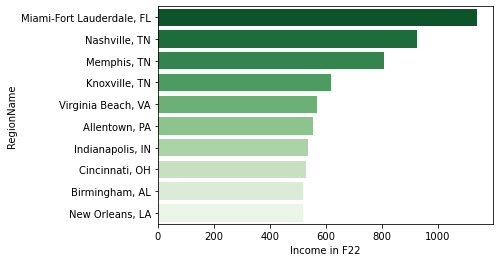

In [48]:
import seaborn as sns

sns.barplot(data=profits_table.sort_values(by='Income in F22', ascending=False).head(10), 
            x='Income in F22', y='RegionName', palette='Greens_r')

In [66]:
def graph_results(region, start_year):
    
    #Graph top growers:

    figure(figsize=(8, 6), dpi=80)

    plt.plot(rent_ts[rent_ts['RegionName'] == region][start_year:]['value'], label ='Train & Actuals');
    plt.plot((make_forecast(region)['2020':]), label='Forecast')
    plt.title(region)
    plt.legend();
    
    return check_forecast(region)

/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Average Monthly Accuracy:
1.0

RMSE:
12.3


,Actuals,Preds,Accuracy
time,,,
2020-12-01,2056,2055,1.00
2021-01-01,2077,2079,1.00
2021-02-01,2116,2110,1.00
2021-03-01,2155,2145,1.00
2021-04-01,2195,2184,0.99
2021-05-01,2235,2226,1.00
2021-06-01,2276,2271,1.00
2021-07-01,2317,2319,1.00
2021-08-01,2360,2366,1.00


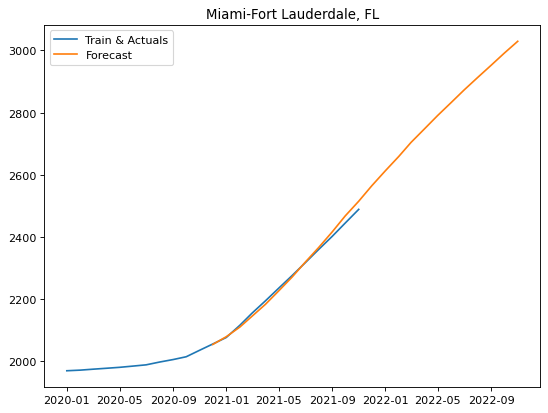

In [62]:
graph_results('Miami-Fort Lauderdale, FL', '2020')

/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Average Monthly Accuracy:
0.99

RMSE:
17.74


,Actuals,Preds,Accuracy
time,,,
2020-12-01,1569,1565,1.00
2021-01-01,1580,1577,1.00
2021-02-01,1601,1589,0.99
2021-03-01,1622,1604,0.99
2021-04-01,1643,1622,0.99
2021-05-01,1665,1643,0.99
2021-06-01,1687,1667,0.99
2021-07-01,1709,1693,0.99
2021-08-01,1732,1725,1.00


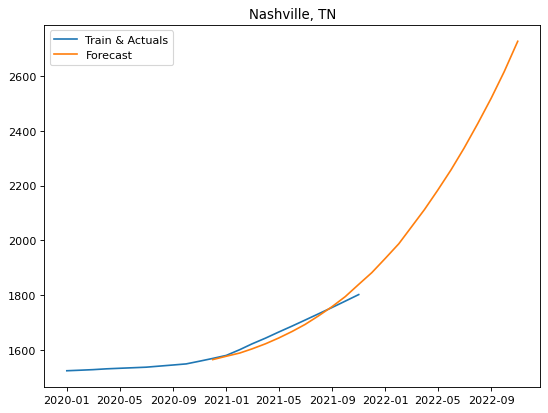

In [63]:
graph_results('Nashville, TN', '2020')

/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warn

Average Monthly Accuracy:
1.0

RMSE:
2.95


,Actuals,Preds,Accuracy
time,,,
2020-12-01,1294,1293,1.0
2021-01-01,1308,1308,1.0
2021-02-01,1324,1322,1.0
2021-03-01,1341,1338,1.0
2021-04-01,1358,1354,1.0
2021-05-01,1374,1370,1.0
2021-06-01,1391,1388,1.0
2021-07-01,1408,1405,1.0
2021-08-01,1425,1423,1.0


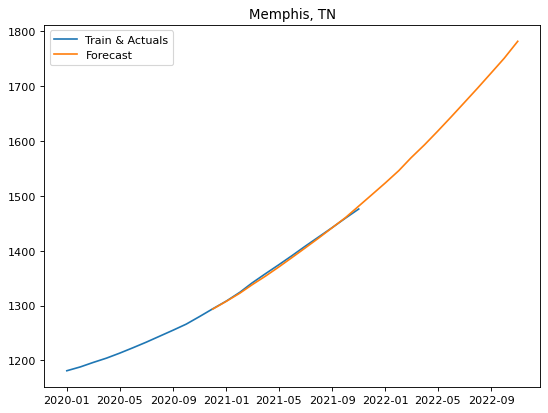

In [64]:
graph_results('Memphis, TN', '2020')

/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/angelogayanelo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warn

Average Monthly Accuracy:
1.0

RMSE:
5.23


,Actuals,Preds,Accuracy
time,,,
2020-12-01,1972,1977,1.00
2021-01-01,1973,1982,1.00
2021-02-01,1987,1994,1.00
2021-03-01,2001,2004,1.00
2021-04-01,2015,2015,1.00
2021-05-01,2030,2031,1.00
2021-06-01,2045,2045,1.00
2021-07-01,2060,2060,1.00
2021-08-01,2077,2076,1.00


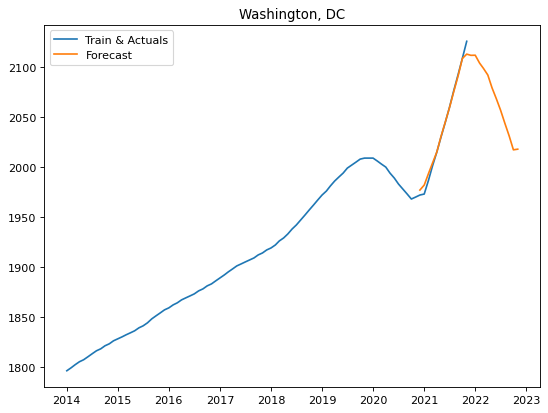

In [67]:
graph_results('Washington, DC', '2000')